<a href="https://colab.research.google.com/github/ppchen1997/.githob.io/blob/master/landmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
!pip install wget
import wget
url = "https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip"
filename = wget.download(url)


  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=8551ae58721baf724745f08043eaa0f12e9270e50691f1cdb3aabfcd4e39147e
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
import zipfile
with zipfile.ZipFile(filename,"r") as zip_ref:
    zip_ref.extractall("data")

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
%matplotlib inline
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import os

In [4]:
!pip install split-folders
import splitfolders 

## Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
output = splitfolders.ratio("/content/data/landmark_images/test", 
                            output="test_and_val", seed=1337, ratio=(.5, .5), group_prefix=None)

Copying files: 1250 files [00:00, 2995.77 files/s]


In [21]:
!mv /content/test_and_val/train /content/test_and_val/test 
#Because splitfolders can only split files into train and val,
#so I renamed the ''train'' folder under the "test_and_val" folder to 'test'

In [23]:


train_dir = '/content/data/landmark_images/train'
val_dir = '/content/test_and_val/val'
test_dir = '/content/test_and_val/test'

mean = [0.485, 0.456, 0.406]
std = [0.229 , 0.224, 0.225]
train_data_transform = transforms.Compose([transforms.Resize(32),
                                          transforms.CenterCrop(32),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean, std)])
valid_test_data_transform = transforms.Compose([
                                         transforms.Resize(32),
                                         transforms.CenterCrop(32),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean,std)])                                   

train_data = datasets.ImageFolder(train_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(val_dir,transform=valid_test_data_transform)
test_data = datasets.ImageFolder(test_dir,transform=valid_test_data_transform)

# print out some data stats
print('Num training images: \t', len(train_data))
print('Num val images: \t', len(valid_data))
print('Num test images: \t', len(test_data))

Num training images: 	 4996
Num val images: 	 650
Num test images: 	 600


In [122]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

num_workers = 4
batch_size = 128
#valid_size = 0.2

# # obtain training indices that will be used for validation
# num_train = len(train_data)
# indices = list(range(num_train))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size * num_train))
# train_idx, valid_idx = indices[split:], indices[:split]

# # define samplers for obtaining training and validation batches
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
     num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
     num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}


**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
Initially I resize the image to 256 X 256, but I found that the training speed is super slow, so I changed to 32 X 32 and then it was much faster

I have done data augmentation, mainly RandomHorizontalFlip and Normalize, the former is to say that landscape photos turn left and right is very reasonable, because usually people will have various angles when taking landscape photos.
In addition, I refer to the parameters of ResNet and set the standard deviation and variance as its parameters.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

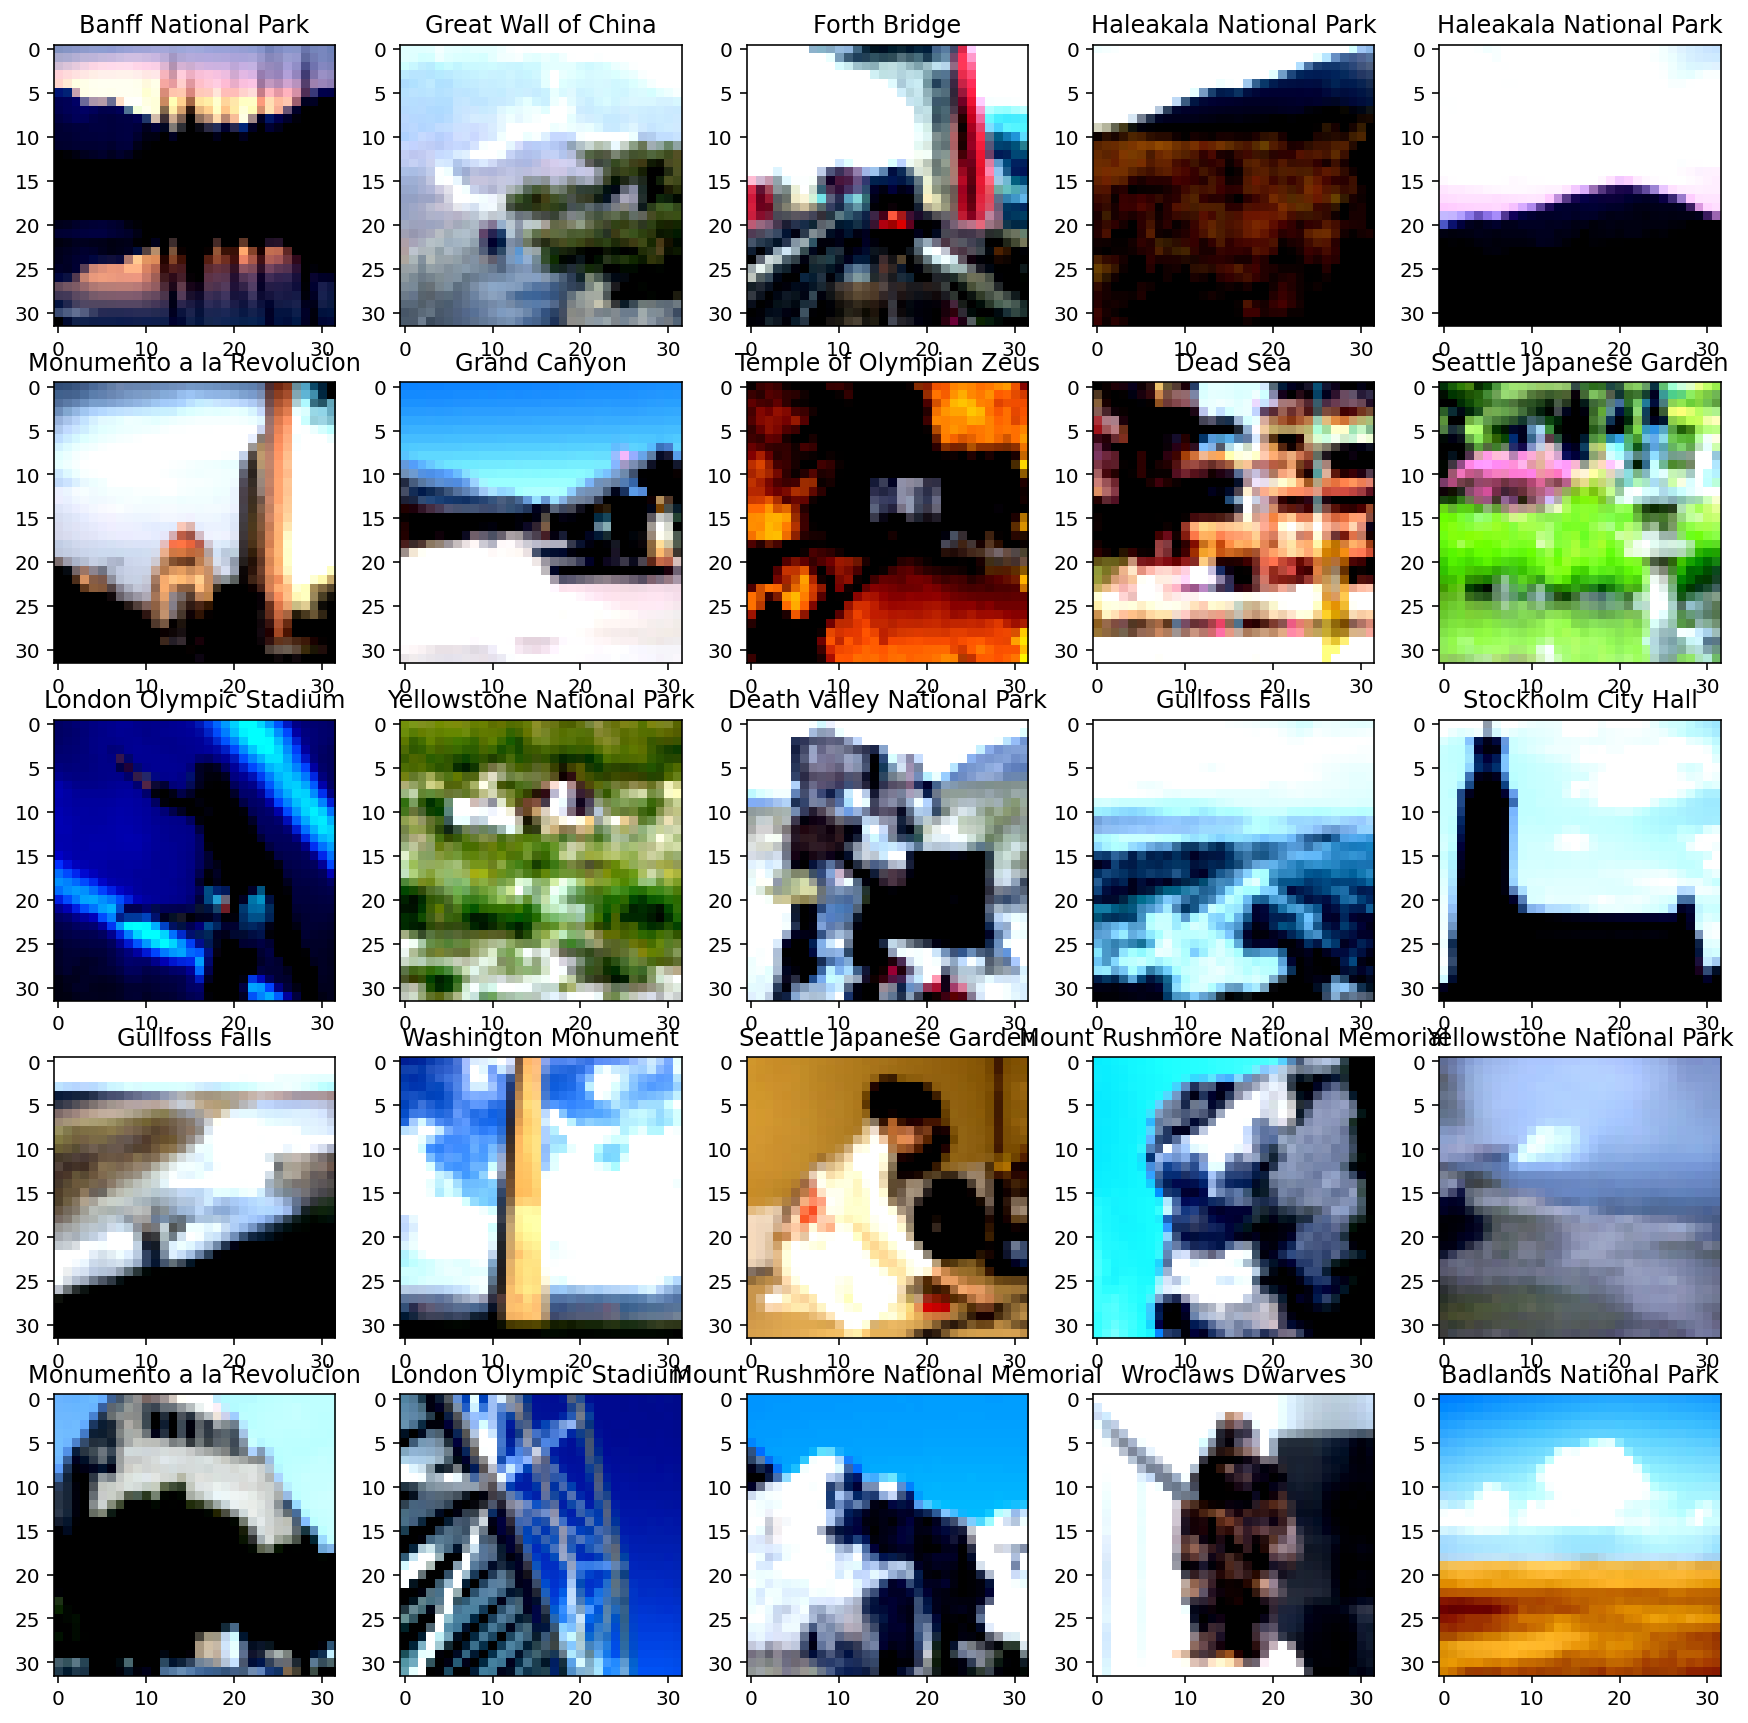

In [26]:
## the class names can be accessed at the `classes` attribute
classes = [item[3:].replace("_", " ") for item in loaders_scratch['train'].dataset.classes]
## of your dataset object (e.g., `train_dataset.classes`)

%matplotlib inline

## TODO: visualize a batch of the train data loader
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print(images.shape)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 20))
fig.set_size_inches(15, 15)
for i in np.arange(25):
    ax = fig.add_subplot(5, 5, i+1)
    plt.imshow(np.transpose(images[i]/2+0.5, (1, 2, 0)))  # unnormalize + convert from Tensor image
    ax.set_title(classes[labels[i]])


### Initialize use_cuda variable

In [30]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [103]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.002)
    return optimizer 
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [216]:
import torch.nn as nn


# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # 32x32x3 image tensor
        self.conv1 = nn.Conv2d(3,16,3, padding=1)
        self.norm1 = nn.LayerNorm(16,16,16)

        # 16x16x32 image tensor
        self.conv2 = nn.Conv2d(16,32,3, padding=1)
        self.norm2 = nn.LayerNorm(8,8,32)

        # 8x8x64 image tensor
        self.conv3 = nn.Conv2d(32,64, 3, padding=1)
        self.norm3 = nn.LayerNorm(4,4,64)

        # 4x4x64 image tensor
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(4*4*64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 50)
        self.dropout = nn.Dropout(p=0.4)

        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x)) 
        x = self.pool(x)
        #x = self.norm1(x) 
        x = F.relu(self.conv2(x)) 
        x = self.pool(x) 
        #x = self.norm2(x) 
        x = F.relu(self.conv3(x))   
        x = self.pool(x)
        #x = self.norm3(x) 
        
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.softmax(x)
        
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
Originally, I let each layer of the CNN have two layers, but found that it would overfit, so it was set to one layer. In addition, I refer to the information on the Internet, I found that usually set up like this.


INPUT -> [[CONV -> RELU] N -> POOL?] M -> [FC -> RELU] * K -> FC

N, M, K is >0 and < 3

Furthermore, since our data set is small, we don't need to set it too deep.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [75]:
def train(n_epochs, loaders, model, optimizer , criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            # Clear the gradients from all Variables
            optimizer.zero_grad()
           
            # Forward pass
            output = model(data)
            loss = criterion_scratch(output, target)

            # backward pass
            loss.backward()

            #update weights
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
 

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion_scratch(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))


        # print training/validation statistics 
        scheduler.step()
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        # print('use_cuda: {}  \tMemory Usage:   Allocated: {} GB,  Cached: {}GB'.format(torch.cuda.get_device_name(0),
        #                                   round(torch.cuda.memory_allocated(0)/1024**3,1),
        #                                   round(torch.cuda.memory_reserved(0)/1024**3,1)))


        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if(valid_loss <= valid_loss_min):
            print('Valid loss decresed (\t{:.6f} \t--> \t{:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [104]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if(classname.find('Linear') !=-1):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y,y)
        m.bias.data.fill_(0)

    
    

#-#-# Do NOT modify the code below this line. #-#-#

model_scratch.apply(custom_weight_init)
model_scratch = train(5, loaders_scratch, model_scratch, 
                      get_optimizer_scratch(model_scratch), criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.907692 	Validation Loss: 3.863327
Valid loss decresed (	inf 	--> 	3.863327). Saving model ...
Epoch: 2 	Training Loss: 3.851237 	Validation Loss: 3.797431
Valid loss decresed (	3.863327 	--> 	3.797431). Saving model ...
Epoch: 3 	Training Loss: 3.778638 	Validation Loss: 3.674302
Valid loss decresed (	3.797431 	--> 	3.674302). Saving model ...
Epoch: 4 	Training Loss: 3.700711 	Validation Loss: 3.629295
Valid loss decresed (	3.674302 	--> 	3.629295). Saving model ...
Epoch: 5 	Training Loss: 3.616041 	Validation Loss: 3.552876
Valid loss decresed (	3.629295 	--> 	3.552876). Saving model ...


In [97]:
from torchsummary import summary
summary(model_scratch,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
         LayerNorm-3           [-1, 16, 16, 16]              32
            Conv2d-4           [-1, 32, 16, 16]           4,640
         MaxPool2d-5             [-1, 32, 8, 8]               0
         LayerNorm-6             [-1, 32, 8, 8]              16
            Conv2d-7             [-1, 64, 8, 8]          18,496
         MaxPool2d-8             [-1, 64, 4, 4]               0
         LayerNorm-9             [-1, 64, 4, 4]               8
           Linear-10                  [-1, 256]         262,400
          Dropout-11                  [-1, 256]               0
           Linear-12                  [-1, 128]          32,896
          Dropout-13                  [-1, 128]               0
           Linear-14                   

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [118]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 20

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)



Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): LayerNorm((16,), eps=16, elementwise_affine=16)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): LayerNorm((8,), eps=8, elementwise_affine=32)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): LayerNorm((4,), eps=4, elementwise_affine=64)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=50, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [123]:
# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, 
                      get_optimizer_scratch(model_scratch),  
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.282824 	Validation Loss: 3.086036
Valid loss decresed (	inf 	--> 	3.086036). Saving model ...
Epoch: 2 	Training Loss: 3.200559 	Validation Loss: 3.075642
Valid loss decresed (	3.086036 	--> 	3.075642). Saving model ...
Epoch: 3 	Training Loss: 3.074806 	Validation Loss: 2.948767
Valid loss decresed (	3.075642 	--> 	2.948767). Saving model ...
Epoch: 4 	Training Loss: 3.037120 	Validation Loss: 2.864681
Valid loss decresed (	2.948767 	--> 	2.864681). Saving model ...
Epoch: 5 	Training Loss: 2.977544 	Validation Loss: 2.863811
Valid loss decresed (	2.864681 	--> 	2.863811). Saving model ...
Epoch: 6 	Training Loss: 2.957082 	Validation Loss: 2.854846
Valid loss decresed (	2.863811 	--> 	2.854846). Saving model ...
Epoch: 7 	Training Loss: 2.893107 	Validation Loss: 2.770390
Valid loss decresed (	2.854846 	--> 	2.770390). Saving model ...
Epoch: 8 	Training Loss: 2.891015 	Validation Loss: 2.631146
Valid loss decresed (	2.770390 	--> 	2.631146). Saving model .

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [124]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.555542


Test Accuracy: 36% (216/600)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [22]:
os.getcwd()

'/content'

In [160]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_dir = '/content/data/landmark_images/train'
val_dir = '/content/test_and_val/val'
test_dir = '/content/test_and_val/test'

mean = [0.485, 0.456, 0.406]
std = [0.229 , 0.224, 0.225]
train_data_transform = transforms.Compose([transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(), 
                                          transforms.Normalize(mean, std)])
valid_test_data_transform = transforms.Compose([
                                         transforms.Resize(224),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean,std)])                                   

train_data = datasets.ImageFolder(train_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(val_dir,transform=valid_test_data_transform)
test_data = datasets.ImageFolder(test_dir,transform=valid_test_data_transform)

# print out some data stats
print('Num training images: \t', len(train_data))
print('Num val images: \t', len(valid_data))
print('Num test images: \t', len(test_data))
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

num_workers = 4
batch_size = 128


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
     num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
     num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

loaders_transfer = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}






Num training images: 	 4996
Num val images: 	 650
Num test images: 	 600


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [161]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.002)
    return optimizer

    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [237]:
## TODO: Specify model architecture

model_transfer = models.resnet152(pretrained=True)
#print(model_transfer)


# freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False

# modify last layer to match it our classes


n_inputs = model_transfer.fc.in_features

last_layer = nn.Sequential(
                          nn.Dropout(0.3),
                          nn.Linear(n_inputs, 50))

model_transfer.fc = last_layer

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
I think the best  architecture is to use the pre-trained model to capture the features of the images first, and then use the fc layer to do the classification, here are my two steps：


step 1: select pretrained model

resnet152 is a relatively new model for picture recognition. Compared with VGG16, the success rate of classification can be about 20% higher. 

step 2: fc layer architecture(last layer)

The default classifier layer is swapped with a new classifier layer to adapt the network for this classifivation problem.
Accroding to Information on the Internet  the last layer architecture usually is: [[FC -> RELU] * K -> FC ]
I have tried last_layer from one to three layers, and I found that one layer works better. Also, to avoid overfitting, I used dropout.In addition, I tried 0.001 to 0.003 learning rate and found the former to be more effective.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [238]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs = 15


#-#-# Do NOT modify the code below this line. #-#-#
model_transfer = train(num_epochs, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.329815 	Validation Loss: 1.209783
Valid loss decresed (	inf 	--> 	1.209783). Saving model ...
Epoch: 2 	Training Loss: 1.153623 	Validation Loss: 0.932588
Valid loss decresed (	1.209783 	--> 	0.932588). Saving model ...
Epoch: 3 	Training Loss: 0.980907 	Validation Loss: 0.834281
Valid loss decresed (	0.932588 	--> 	0.834281). Saving model ...
Epoch: 4 	Training Loss: 0.811387 	Validation Loss: 0.837351
Epoch: 5 	Training Loss: 0.703981 	Validation Loss: 0.829756
Valid loss decresed (	0.834281 	--> 	0.829756). Saving model ...
Epoch: 6 	Training Loss: 0.694995 	Validation Loss: 0.753597
Valid loss decresed (	0.829756 	--> 	0.753597). Saving model ...
Epoch: 7 	Training Loss: 0.595099 	Validation Loss: 0.771249
Epoch: 8 	Training Loss: 0.576539 	Validation Loss: 0.766255
Epoch: 9 	Training Loss: 0.567185 	Validation Loss: 0.745146
Valid loss decresed (	0.753597 	--> 	0.745146). Saving model ...
Epoch: 10 	Training Loss: 0.556089 	Validation Loss: 0.794494
Epoc

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [239]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.817286


Test Accuracy: 77% (464/600)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [242]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    image = test_data_transform(Image.open(img_path)).unsqueeze_(0)

    # get k predictions 
    model_transfer.eval()
    output = model_transfer(image.cuda())
    _, preds_tensor = torch.topk(output,k) 
    #print(preds_tensor)
    preds = preds_tensor.cpu().numpy()
    #print(preds)
    
    # creat an array with all the possible classes we found
    res =[classes[i] for i in preds[0]]

    # show image 
    # img = Image.open(img_path)
    # plt.imshow(img)
    # plt.show()
    return  res
    
  
    


# test on a sample image
predict_landmarks('/content/data/landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Brooklyn Bridge',
 'Pont du Gard',
 'Forth Bridge',
 'Dead Sea']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

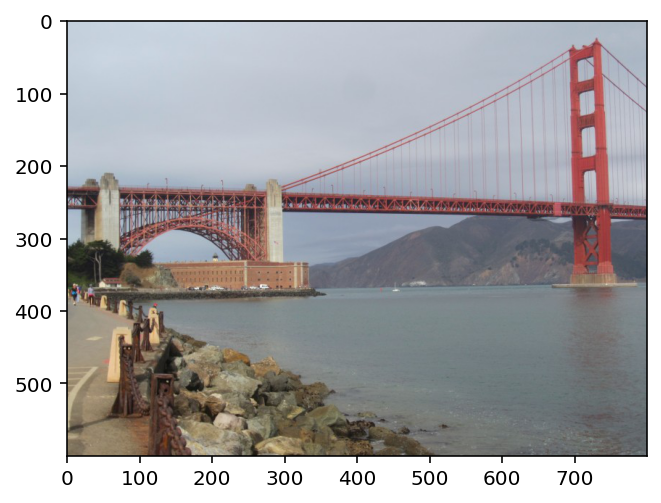

top 3 most likely landmarks for this photo are :
Golden Gate Bridge  ,  Brooklyn Bridge  ,  Pont du Gard


In [252]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    # show image 
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    print('top 3 most likely landmarks for this photo are :')

    print(predicted_landmarks[0],' , ',
          predicted_landmarks[1],' , ',
          predicted_landmarks[2])

    
    

# test on a sample image
suggest_locations('/content/data/landmark_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
Maybe the photos I provided are not in the original category haha
But when I looked for the computer's guess of the first place location to compare the photos, it did look quite similar
The AI is really good and interesting!

1, More datasets
2, Better data argumentation
3, Better hyperparameter fine-tuning
4, More training steps

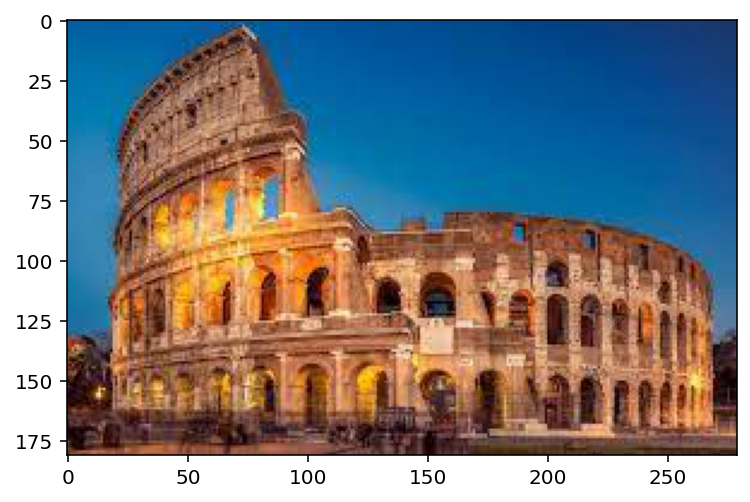

top 3 most likely landmarks for this photo are :
Kantanagar Temple  ,  Vienna City Hall  ,  Terminal Tower


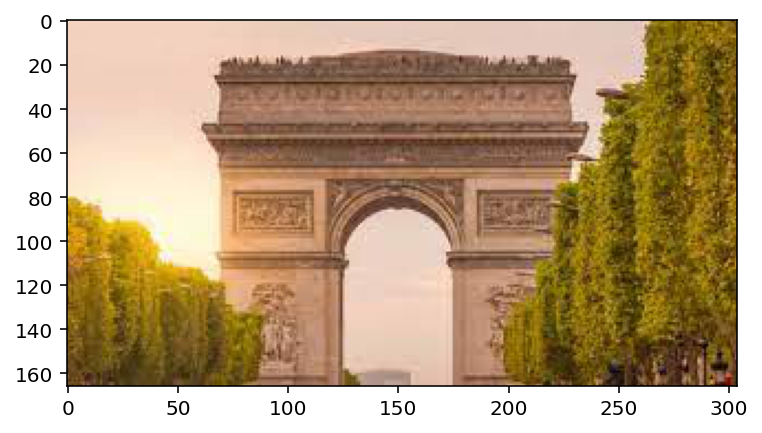

top 3 most likely landmarks for this photo are :
Central Park  ,  Pont du Gard  ,  Taj Mahal


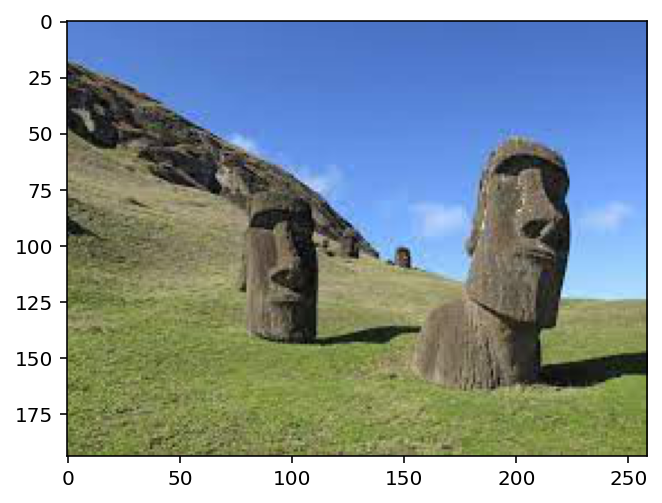

top 3 most likely landmarks for this photo are :
Stonehenge  ,  Whitby Abbey  ,  Machu Picchu


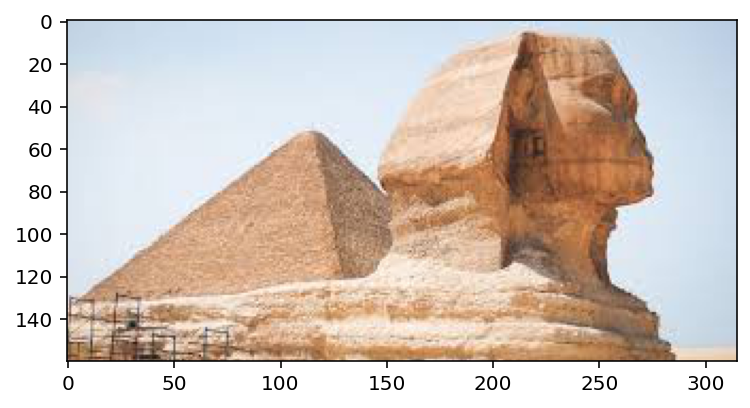

top 3 most likely landmarks for this photo are :
Death Valley National Park  ,  Badlands National Park  ,  Dead Sea


In [253]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('/content/01.jpeg')

suggest_locations('/content/02.jpeg')

suggest_locations('/content/03.jpeg')

suggest_locations('/content/04.jpeg')
